# Simple Unet Baseline (Train)

This is the training part of the two part Unet Baseline for this competition.
#### Inference Notebook: [Simple Unet Baseline (Infer)][1]. 
You can find the notebook to create the dataset used for training [here][2] to get a better understanding of how everything works.
* Smp library is used to get the unet model.
* EfficientNetB0 is used as the backbone initialized on imagenet weight.
* Ash color images are used for training (With only the labeled frames and human_pixel_masks.
* Custom implementation of dice score is used according to this competition.
* After training, we find the best threshold for the valid set, which will then be used for the submission.
* Wandb can also be used with this notebook to log experiments, just uncomment the wandb code snippets.

**Version 5** Updates:
* Added some Augmentations
* Trained for more Epochs
* Option to increase image size

### Please upvote if you find this useful.

[1]: https://www.kaggle.com/code/shashwatraman/simple-unet-pytorch-baseline-infer
[2]: https://www.kaggle.com/code/shashwatraman/contrails-dataset-ash-color/notebook

## Import Libraries

In [1]:
from pathlib import Path
import os
import random
import math
from collections import defaultdict
import cv2
import skimage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import torch.nn.functional as F

from PIL import Image
from tqdm.notebook import tqdm
from transformers import get_cosine_schedule_with_warmup

torch.__version__

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

'2.0.0'

In [2]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0b026572073319ebf4d93eb7f8348a2d0f877abf40d600da40f2c90020e16b77
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=e4119787c3529596ec98df9ba8d7e71bb5e4c0d10dcdc57bc7bc13cc26dad3e6
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
# !pip install -qU wandb
# import wandb
# wandb.login(key='')

## Data Preparation

In [4]:
class Config:
    train = True
    train_aug=True
    
    num_epochs = 30
    num_classes = 1
    batch_size = 32
    seed = 42
    
    encoder = 'efficientnet-b3'
    pretrained = True
    weights = 'imagenet'
    classes = ['contrail']
    activation = None
    in_chans = 3
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    image_size = 256
    warmup = 0
    lr = 3e-3
    
class Paths:
    data_root = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    contrails = '/kaggle/input/contrails-images-ash-color/contrails/'
    train_path = '/kaggle/input/contrails-images-ash-color/train_df.csv'
    valid_path = '/kaggle/input/contrails-images-ash-color/valid_df.csv'

In [5]:
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
set_seed(9)

In [7]:
# Import dataframes
train_df = pd.read_csv(Paths.train_path)
valid_df = pd.read_csv(Paths.valid_path)

train_df['path'] = Paths.contrails + train_df['record_id'].astype(str) + '.npy'
valid_df['path'] = Paths.contrails + valid_df['record_id'].astype(str) + '.npy'

train_df.shape, valid_df.shape

((20529, 3), (1856, 3))

In [8]:
transform_size = A.Compose([
    A.Resize(Config.image_size, Config.image_size, interpolation=cv2.INTER_LANCZOS4, always_apply=True)
])

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.75, 1.0), p=0.6)
])

In [9]:
class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, train=True, transform=None):
        
        self.df = df
        self.trn = train
        self.transform = transform
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        con = np.load(str(con_path))
        
        img = con[..., :-1]
        label = con[..., -1]
        
        img = img.astype(np.float32)
        label = label.astype(np.float32)
        
        if Config.train_aug:
            if self.transform is not None:
                augmented = self.transform(image=img, mask=label)
                img = augmented['image']
                label = augmented['mask']
                
        if Config.image_size != 256:
            img = transform_size(image=img)["image"]
        
        img = torch.tensor(img)
        label = torch.tensor(label)
        
        img = img.permute(2, 0, 1)
            
        return img.float(), label.float()
    
    def __len__(self):
        return len(self.df)

In [10]:
train_ds = ContrailsDataset(
        train_df,
        train=True,
        transform=train_transform
    )

valid_ds = ContrailsDataset(
        valid_df,
        train=False,
        transform=None
    )

train_dl = DataLoader(train_ds, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
valid_dl = DataLoader(valid_ds, batch_size=Config.batch_size, num_workers = 2)

In [11]:
img, label = next(iter(train_dl))
img.shape, label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

In [12]:
img, label = next(iter(valid_dl))
img.shape, label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

In [13]:
def display_random_images(dataset, n=10, seed=None):
    if seed:
        random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(30, 20))
    
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        targ_image = targ_image.permute(1, 2, 0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image)
        plt.axis(False)

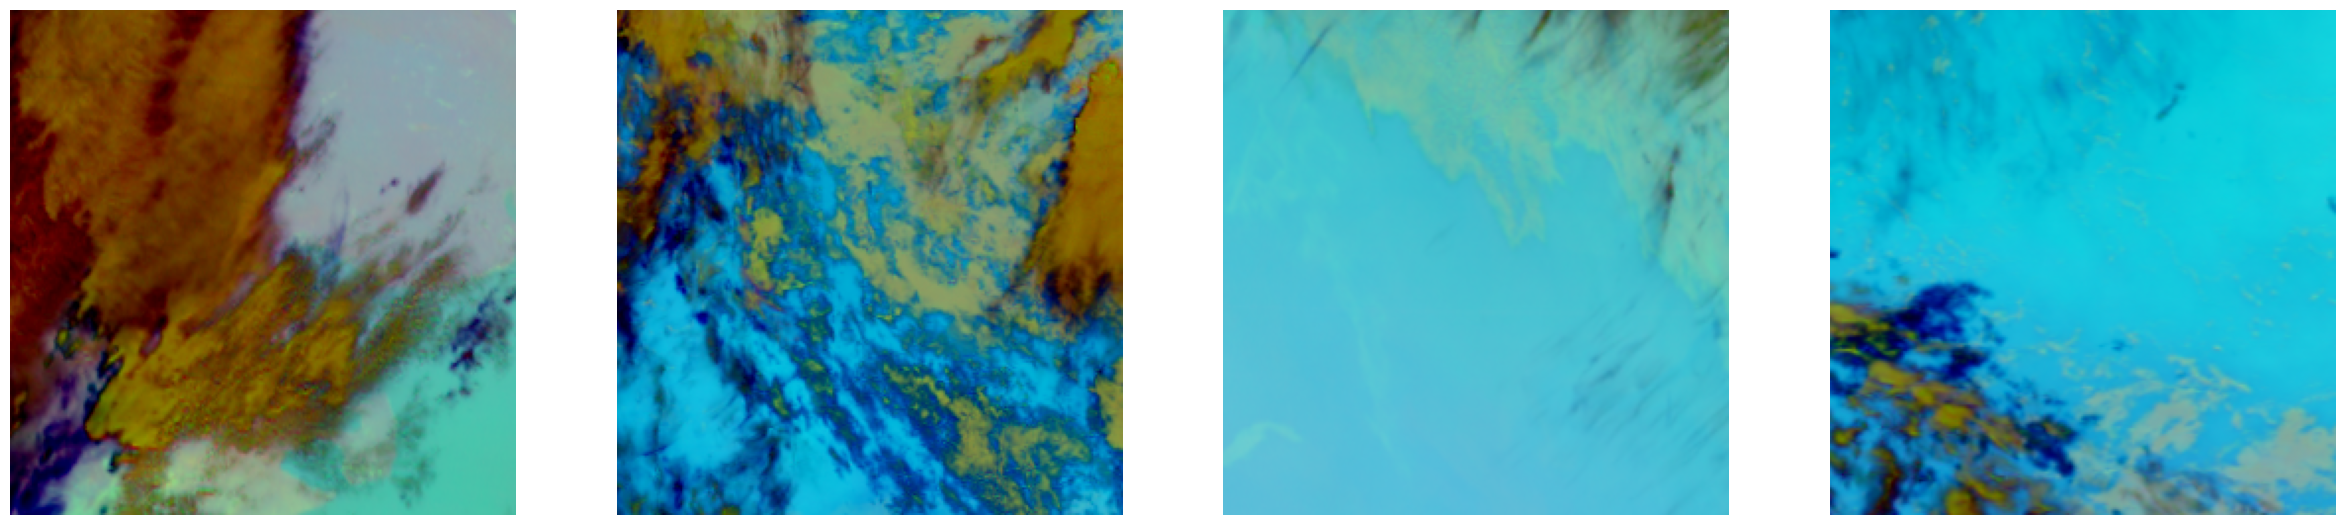

In [14]:
display_random_images(train_ds, 4, 42)

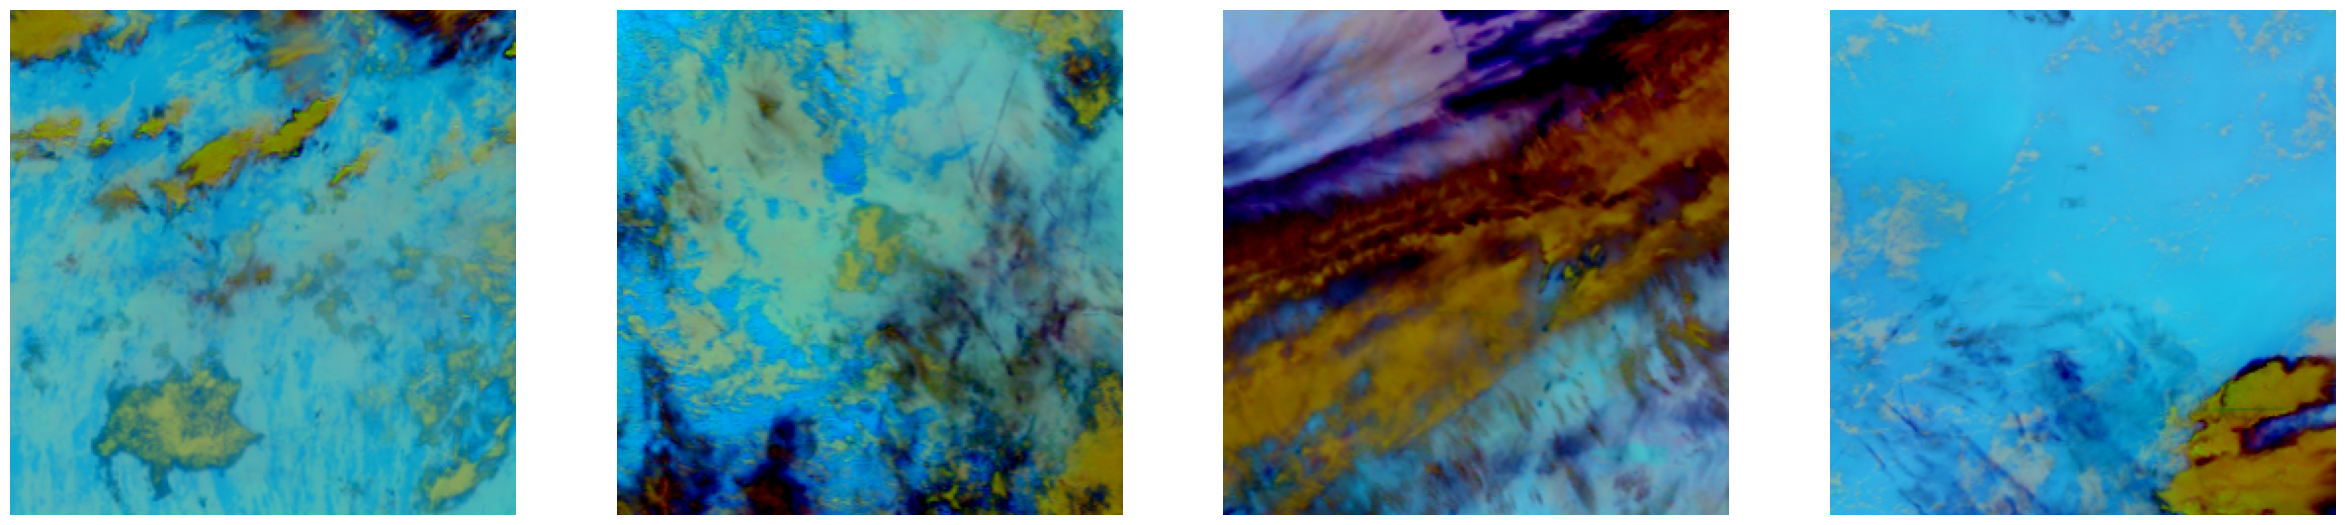

In [15]:
display_random_images(valid_ds, 4, 42)

## Training

In [16]:
def dice_coef(y_true, y_pred, thr=0.5, epsilon=0.001):
    y_true = y_true.flatten()
    y_pred = (y_pred>thr).astype(np.float32).flatten()
    inter = (y_true*y_pred).sum()
    den = y_true.sum() + y_pred.sum()
    dice = ((2*inter+epsilon)/(den+epsilon))
    return dice

In [17]:
class UNet(nn.Module):
    def __init__(self, cfg):
        super(UNet, self).__init__()
        
        self.cfg = cfg
        self.training = True
        
        self.model = smp.Unet(
            encoder_name=cfg.encoder, 
            encoder_weights=cfg.weights, 
            decoder_use_batchnorm=True,
            classes=len(cfg.classes), 
            activation=cfg.activation,
        )
        
        self.loss_fn = smp.losses.DiceLoss(mode='binary')
    
    def forward(self, imgs, targets):
        
        x = imgs
        y = targets

        logits = self.model(x)
        
        if Config.image_size != 256:
            logits = F.interpolate(logits, size=(256, 256), mode='nearest-exact')
        
        loss = self.loss_fn(logits, y)
        
        return {"loss": loss, "logits": logits.sigmoid(), "logits_raw": logits, "target": y}

In [18]:
def train_step(model, dataloader, optimizer, device):
    
    model.train()
    
    train_losses = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    
    for step, (X, y) in pbar:
        
        X, y = X.to(device), y.to(device)
        torch.set_grad_enabled(True)
        
        output_dict = model(X, y)
        loss = output_dict["loss"]
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
    
    train_loss = np.sum(train_losses)
    
    return train_loss

In [19]:
def test_step(model, dataloader, device):
    
    model.eval()
    torch.set_grad_enabled(False)
    
    val_data = defaultdict(list)
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid')
    for step, (X, y) in pbar: 
        X, y = X.to(device), y.to(device)

        output = model(X, y)
        for key, val in output.items():
            val_data[key] += [output[key]]

    for key, val in output.items():
        value = val_data[key]
        if len(value[0].shape) == 0:
            val_data[key] = torch.stack(value)
        else:
            val_data[key] = torch.cat(value, dim=0).cpu().detach().numpy()
    
    val_losses = val_data["loss"].cpu().numpy()
    val_loss = np.sum(val_losses)
    
    val_dice = dice_coef(val_data['target'], val_data['logits'])
    
    return val_loss, val_dice

In [20]:
from tqdm.auto import tqdm

In [21]:
def train(model, train_dataloader, test_dataloader, optimizer, epochs, device):
    results = {'train_loss': [],
              'val_loss': [],
              'val_dice': []}
    for epoch in range(epochs):
        
        set_seed(Config.seed + epoch)
        print("EPOCH:", epoch)
        
        train_loss = train_step(model,
                              train_dataloader,
                              optimizer,
                              device)
        val_loss, val_dice = test_step(model,
                            test_dataloader,
                            device)
        
        train_loss = train_loss / len(train_ds)
        val_loss = val_loss / len(valid_ds)
        
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}')
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['val_dice'].append(val_dice)
        
#         wandb.log({
#         "Train Loss": train_loss,
#         "Valid Loss": val_loss,
#         'Valid Dice': val_dice})
        
        PATH = f"epoch-{epoch}.pth"
        torch.save(model.state_dict(), PATH)
        
#         wandb.save(PATH)

    return results

In [22]:
def get_optimizer(lr, params):
    
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=0)
    
    return model_optimizer

In [23]:
def get_scheduler(cfg, optimizer, total_steps):
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps= cfg.warmup * (total_steps // cfg.batch_size),
        num_training_steps= cfg.num_epochs * (total_steps // cfg.batch_size)
    )
    return scheduler

In [24]:
NUM_EPOCHS = Config.num_epochs
model = UNet(Config).to(Config.device)

# run = wandb.init(project='Google Contrails', 
#                      config={k:v for k, v in dict(vars(Config)).items() if '__' not in k},
#                      name=f"{Config.encoder}-{Config.num_epochs}epos-{Config.lr}-unet"
#                     )

total_steps = len(train_ds)
optimizer = get_optimizer(lr=Config.lr, params=model.parameters())
scheduler = get_scheduler(Config, optimizer, total_steps)

# wandb.watch(model, log_freq=100, log='all')

from timeit import default_timer as timer
start_time = timer()

model_results = train(model, train_dl, valid_dl, optimizer, NUM_EPOCHS, Config.device)

end_time = timer()

# run.finish()
print(f'Total Training Time: {end_time-start_time:.3f} seconds')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 50.3MB/s]


EPOCH: 0


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0163 | Val Loss: 0.0180 | Val Dice: 0.4468
Learning rate: 0.0029917572080239373
EPOCH: 1


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0144 | Val Loss: 0.0178 | Val Dice: 0.4558
Learning rate: 0.002967119423588497
EPOCH: 2


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0139 | Val Loss: 0.0163 | Val Dice: 0.4990
Learning rate: 0.0029263574255361485
EPOCH: 3


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0134 | Val Loss: 0.0151 | Val Dice: 0.5363
Learning rate: 0.002869919204094191
EPOCH: 4


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0131 | Val Loss: 0.0149 | Val Dice: 0.5443
Learning rate: 0.0027984250372877512
EPOCH: 5


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0129 | Val Loss: 0.0164 | Val Dice: 0.4951
Learning rate: 0.002712660673842813
EPOCH: 6


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0127 | Val Loss: 0.0148 | Val Dice: 0.5432
Learning rate: 0.002613568697501823
EPOCH: 7


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0126 | Val Loss: 0.0157 | Val Dice: 0.5221
Learning rate: 0.0025022381676614164
EPOCH: 8


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0125 | Val Loss: 0.0140 | Val Dice: 0.5712
Learning rate: 0.0023798926501856724
EPOCH: 9


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0124 | Val Loss: 0.0146 | Val Dice: 0.5500
Learning rate: 0.002247876769940932
EPOCH: 10


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0123 | Val Loss: 0.0143 | Val Dice: 0.5588
Learning rate: 0.002107641432845055
EPOCH: 11


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0121 | Val Loss: 0.0141 | Val Dice: 0.5643
Learning rate: 0.00196072787984654
EPOCH: 12


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0119 | Val Loss: 0.0132 | Val Dice: 0.5859
Learning rate: 0.0018087507480864947
EPOCH: 13


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0119 | Val Loss: 0.0139 | Val Dice: 0.5700
Learning rate: 0.0016533803254078756
EPOCH: 14


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0117 | Val Loss: 0.0132 | Val Dice: 0.5915
Learning rate: 0.0014963241932418458
EPOCH: 15


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0116 | Val Loss: 0.0133 | Val Dice: 0.5898
Learning rate: 0.0013393084596230844
EPOCH: 16


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0116 | Val Loss: 0.0131 | Val Dice: 0.5961
Learning rate: 0.0011840587885905104
EPOCH: 17


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0115 | Val Loss: 0.0133 | Val Dice: 0.5894
Learning rate: 0.0010322814344676874
EPOCH: 18


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0113 | Val Loss: 0.0127 | Val Dice: 0.6070
Learning rate: 0.0008856444894635653
EPOCH: 19


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0112 | Val Loss: 0.0131 | Val Dice: 0.5959
Learning rate: 0.0007457595506897086
EPOCH: 20


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0112 | Val Loss: 0.0125 | Val Dice: 0.6163
Learning rate: 0.0006141640080806483
EPOCH: 21


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0111 | Val Loss: 0.0130 | Val Dice: 0.6013
Learning rate: 0.0004923041478799883
EPOCH: 22


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0109 | Val Loss: 0.0125 | Val Dice: 0.6130
Learning rate: 0.0003815192573915502
EPOCH: 23


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0109 | Val Loss: 0.0125 | Val Dice: 0.6144
Learning rate: 0.00028302690569051686
EPOCH: 24


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0109 | Val Loss: 0.0124 | Val Dice: 0.6183
Learning rate: 0.00019790956206529426
EPOCH: 25


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0108 | Val Loss: 0.0124 | Val Dice: 0.6169
Learning rate: 0.00012710269925862678
EPOCH: 26


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0107 | Val Loss: 0.0124 | Val Dice: 0.6174
Learning rate: 7.138451225797144e-05
EPOCH: 27


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0107 | Val Loss: 0.0123 | Val Dice: 0.6191
Learning rate: 3.136736562963432e-05
EPOCH: 28


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0108 | Val Loss: 0.0124 | Val Dice: 0.6181
Learning rate: 7.491063393793129e-06
EPOCH: 29


Train :   0%|          | 0/642 [00:00<?, ?it/s]

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0108 | Val Loss: 0.0123 | Val Dice: 0.6196
Learning rate: 1.8015407097782265e-08
Total Training Time: 9333.491 seconds


## Finding the Best Threshold

In [25]:
# Predicting the Valid Set
model.eval()
torch.set_grad_enabled(False)

val_data = defaultdict(list)
pbar = tqdm(enumerate(valid_dl), total=len(valid_dl), desc='Valid')
for step, (X, y) in pbar: 
    X, y = X.to(Config.device), y.to(Config.device)

    output = model(X, y)
    for key, val in output.items():
        val_data[key] += [output[key]]

for key, val in output.items():
    value = val_data[key]
    if len(value[0].shape) == 0:
        val_data[key] = torch.stack(value)
    else:
        val_data[key] = torch.cat(value, dim=0).cpu().detach().numpy()

val_losses = val_data["loss"].cpu().numpy()
val_loss = np.sum(val_losses)
val_loss = val_loss / len(valid_ds)

Valid:   0%|          | 0/58 [00:00<?, ?it/s]

In [26]:
predictions = val_data['logits']
ground_truths = val_data['target']

In [27]:
predictions.shape, ground_truths.shape

((1856, 1, 256, 256), (1856, 256, 256))

In [28]:
# Finding the Best Threshold
bdice = -1
bi = None
for i in tqdm(np.arange(0, 1.01, 0.01)):
    val_dice = dice_coef(ground_truths, predictions, i)
    if val_dice > bdice:
        bdice = val_dice
        bi = i

  0%|          | 0/101 [00:00<?, ?it/s]

In [29]:
print(f'Best Threshold: {bi}')
print(f'Best Validation Dice Score: {bdice}')

Best Threshold: 0.01
Best Validation Dice Score: 0.6216237299559233
